# 核密度估计
- 生成1000个X1~B(10,0.4)
- 生成1000个X2~U(2,4)
- 生成1000个X3~E(4)
- 生成1000个X4~N(1,4)
- X1+X2+X3+X4做核密度估计
  - 直方图：最优带宽
  - KNN：不等长带宽
  - 核密度函数

### 1 生成随机数

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom, uniform, expon, norm
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# 生成随机数
np.random.seed(42)  # 随机种子
X1 = binom.rvs(n=10, p=0.4, size=1000)
X2 = uniform.rvs(loc=2, scale=2, size=1000)
X3 = expon.rvs(scale=1/4, size=1000)
X4 = norm.rvs(loc=1, scale=2, size=1000)

In [2]:
X = X1 + X2 + X3 + X4
X = X.reshape(-1, 1)

### 2 绘制直方图
#### 2.1 理想带宽公式计算最佳带宽
对于公式：
$$h^* = \frac{1}{n^(1/3)}(\frac{6}{\int p'(x)^2dx})^{1/3}$$
由于$p'(x)$未知，因此假设$p(x)$正态分布，公式简化为：
$$h_0 \approx 3.5n^{-1/3}$$

In [3]:
n = len(X)
book_bandwidth = 3.5 * (n ** (-1/3))
print(f"书本上的最佳带宽: {book_bandwidth}")

书本上的最佳带宽: 0.3500000000000001


#### 2.2 KNN核密度估计

In [4]:
# 网格搜索最佳带宽
bandwidths = np.logspace(-1, 1, 20)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)
grid.fit(X)

best_bandwidth = grid.best_params_['bandwidth']
print(f"最佳带宽: {best_bandwidth}")

最佳带宽: 0.6951927961775606


#### 2.3 可视化不同带宽效果
依次为：
- 0.1
- 书本上最佳带宽算法
- KNN核密度估计
- 2.0

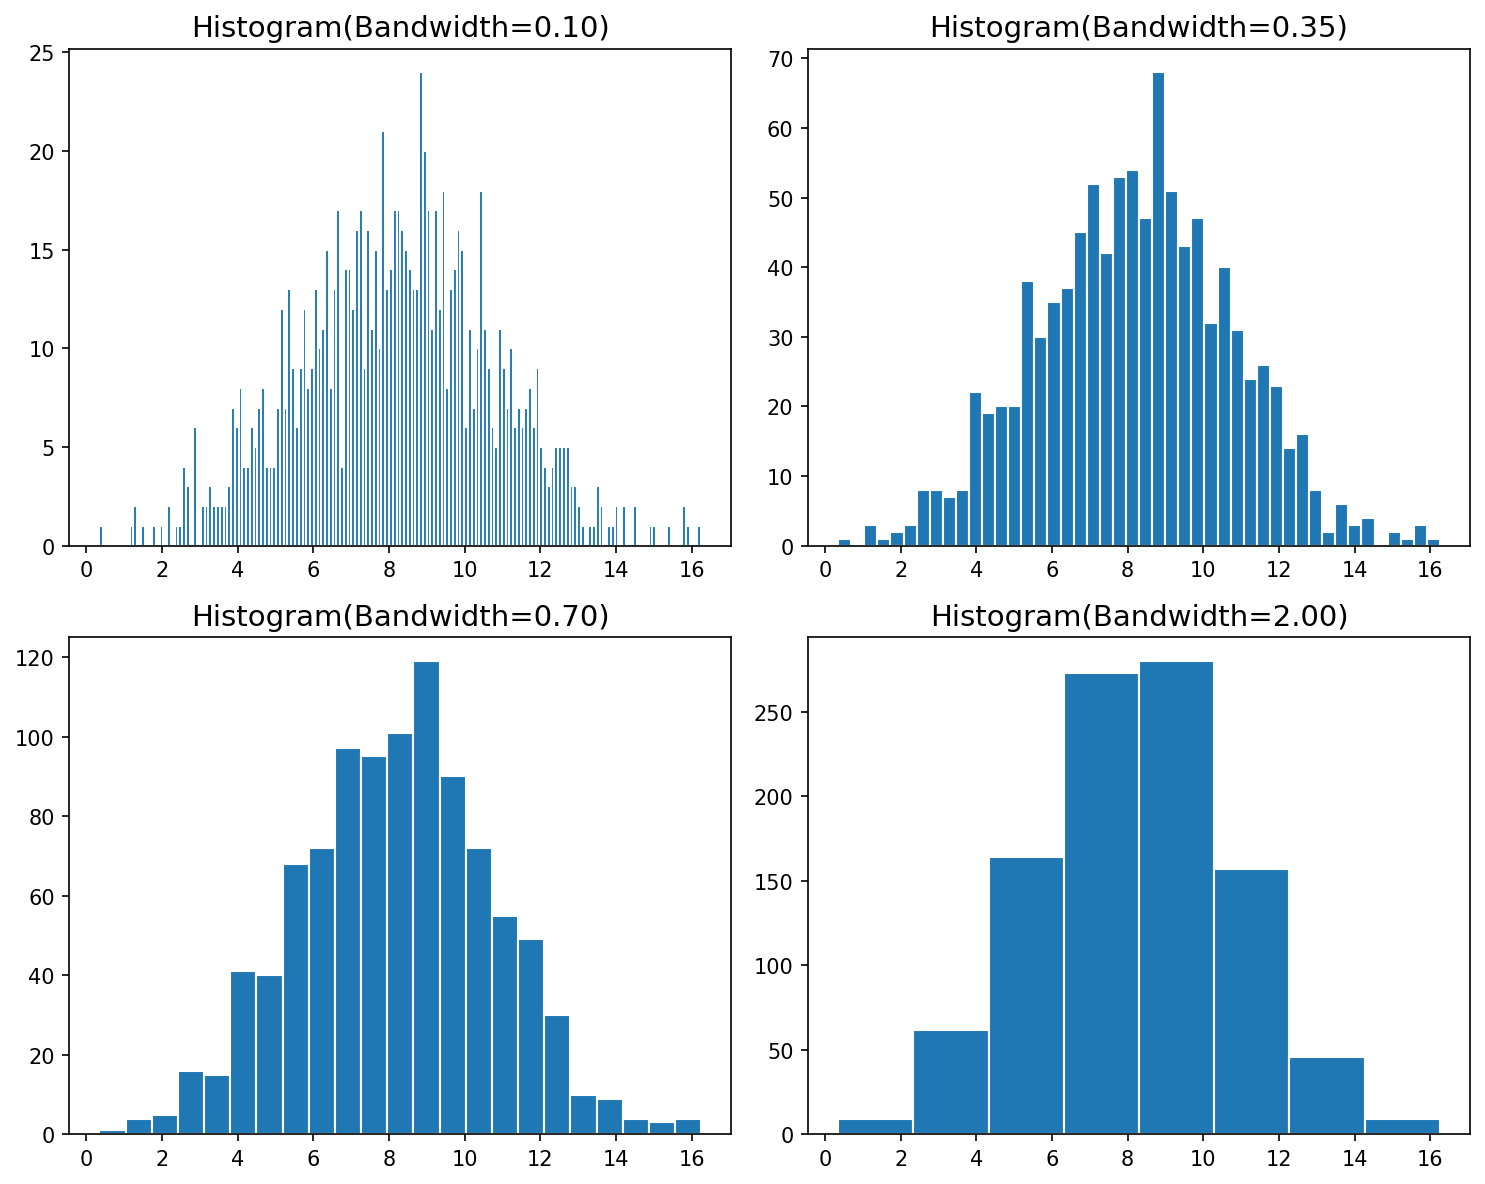

In [5]:
# 计算最小和最大范围
x_min = np.min(X)
x_max = np.max(X)
x_diff = x_max - x_min

# 不同带宽
bandwidths_to_plot = [0.1, book_bandwidth, best_bandwidth, 2.0]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=150)
axes = axes.flatten()

# 循环绘制不同带宽下的直方图
for i, bandwidth in enumerate(bandwidths_to_plot):
    bins = int(np.ceil(x_diff / bandwidth))
    axes[i].hist(X, bins=bins, edgecolor='w')
    axes[i].set_title(f'Histogram(Bandwidth={bandwidth:.2f})', size=14)

plt.tight_layout()
plt.show()

### 3 核密度函数
#### 3.1 同核不同带宽对比
- 核：GAU
- 带宽（同上）
    - 0.1
    - 书本上最佳带宽算法
    - KernelDensity中kernel='gaussian'最佳带宽
    - 2.0

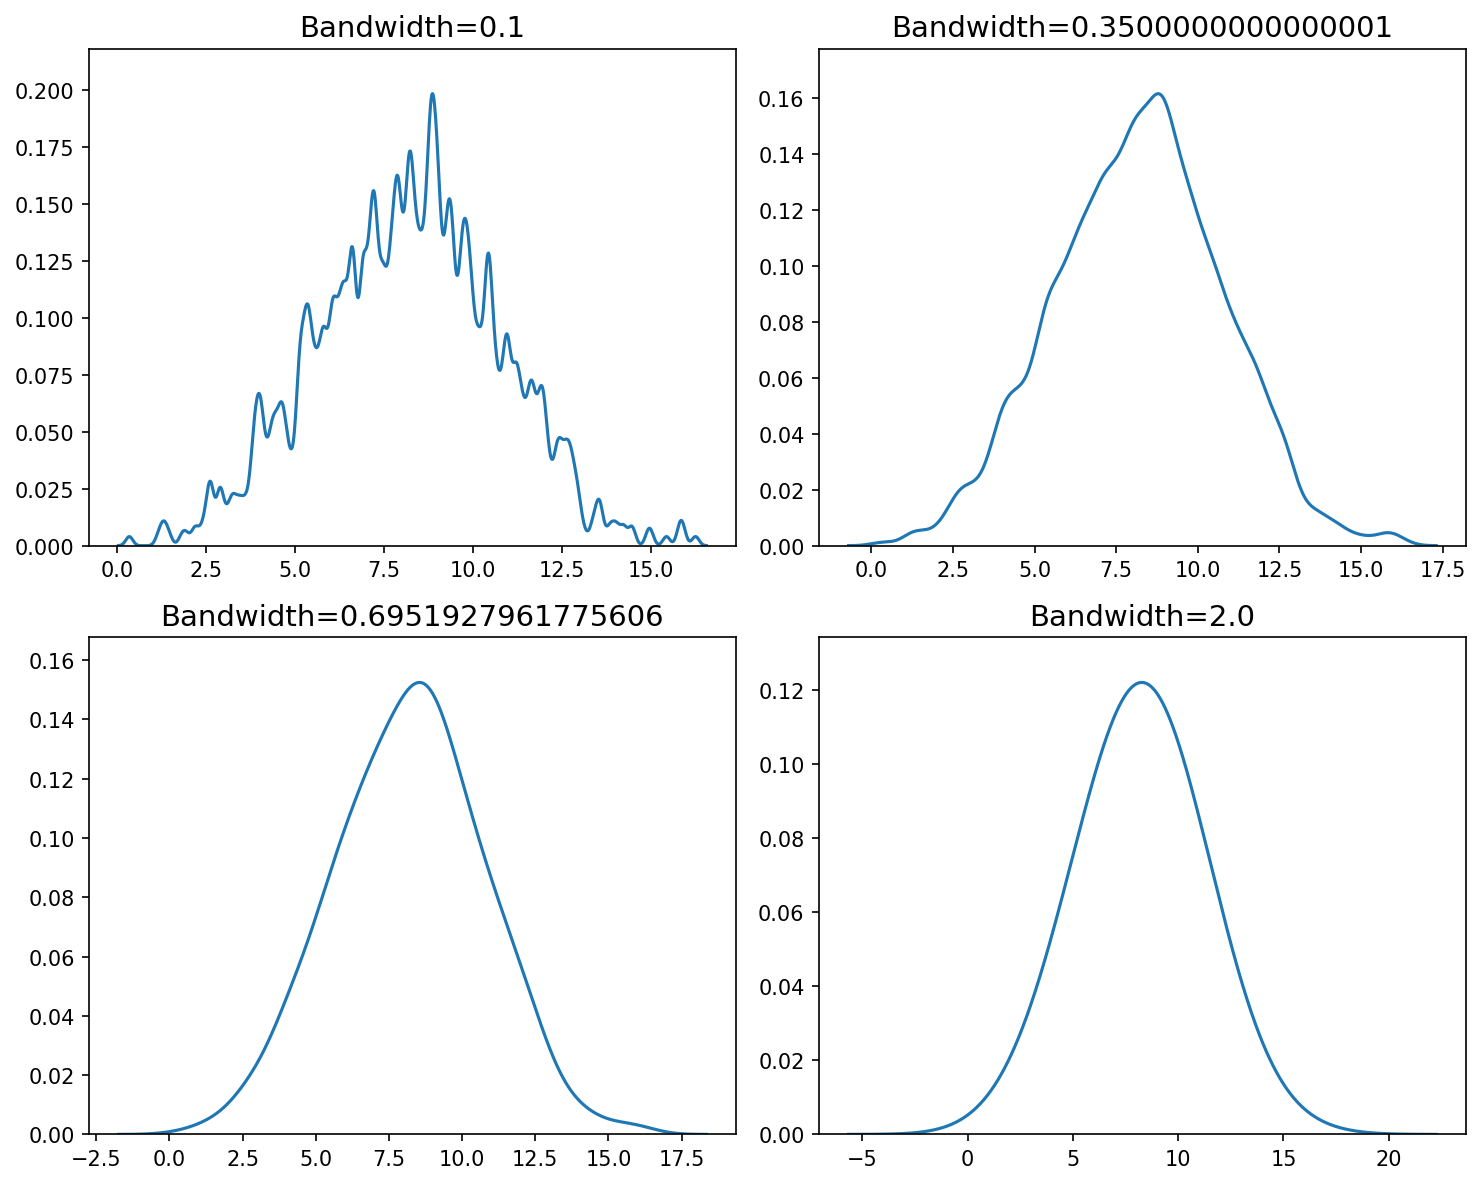

In [6]:
import statsmodels.nonparametric.api as smn

dens = smn.KDEUnivariate(X.flatten())

# 定义的带宽和上述一致
bandwidths_to_plot = bandwidths_to_plot

fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=150)
axes = axes.flatten()

# 循环绘制不同带宽下的核密度估计图
for i, bandwidth in enumerate(bandwidths_to_plot):
    # 进行核密度估计拟合
    result = dens.fit(bw=bandwidth, kernel='gau')
    axes[i].set_title(f'Bandwidth={bandwidth}', size=14)
    # 绘制核密度估计曲线
    axes[i].plot(dens.support, result.density)
    axes[i].set_ylim(0, max(result.density) * 1.1)

plt.tight_layout()
plt.show()

#### 3.2 不同核同带宽对比
- 带宽：书本上算法的最佳带宽
- 核：
    - 高斯核
    - 双权核
    - 余弦核
    - Epanechnikov核
    - 三角核
    - 三权核
    - 均匀核

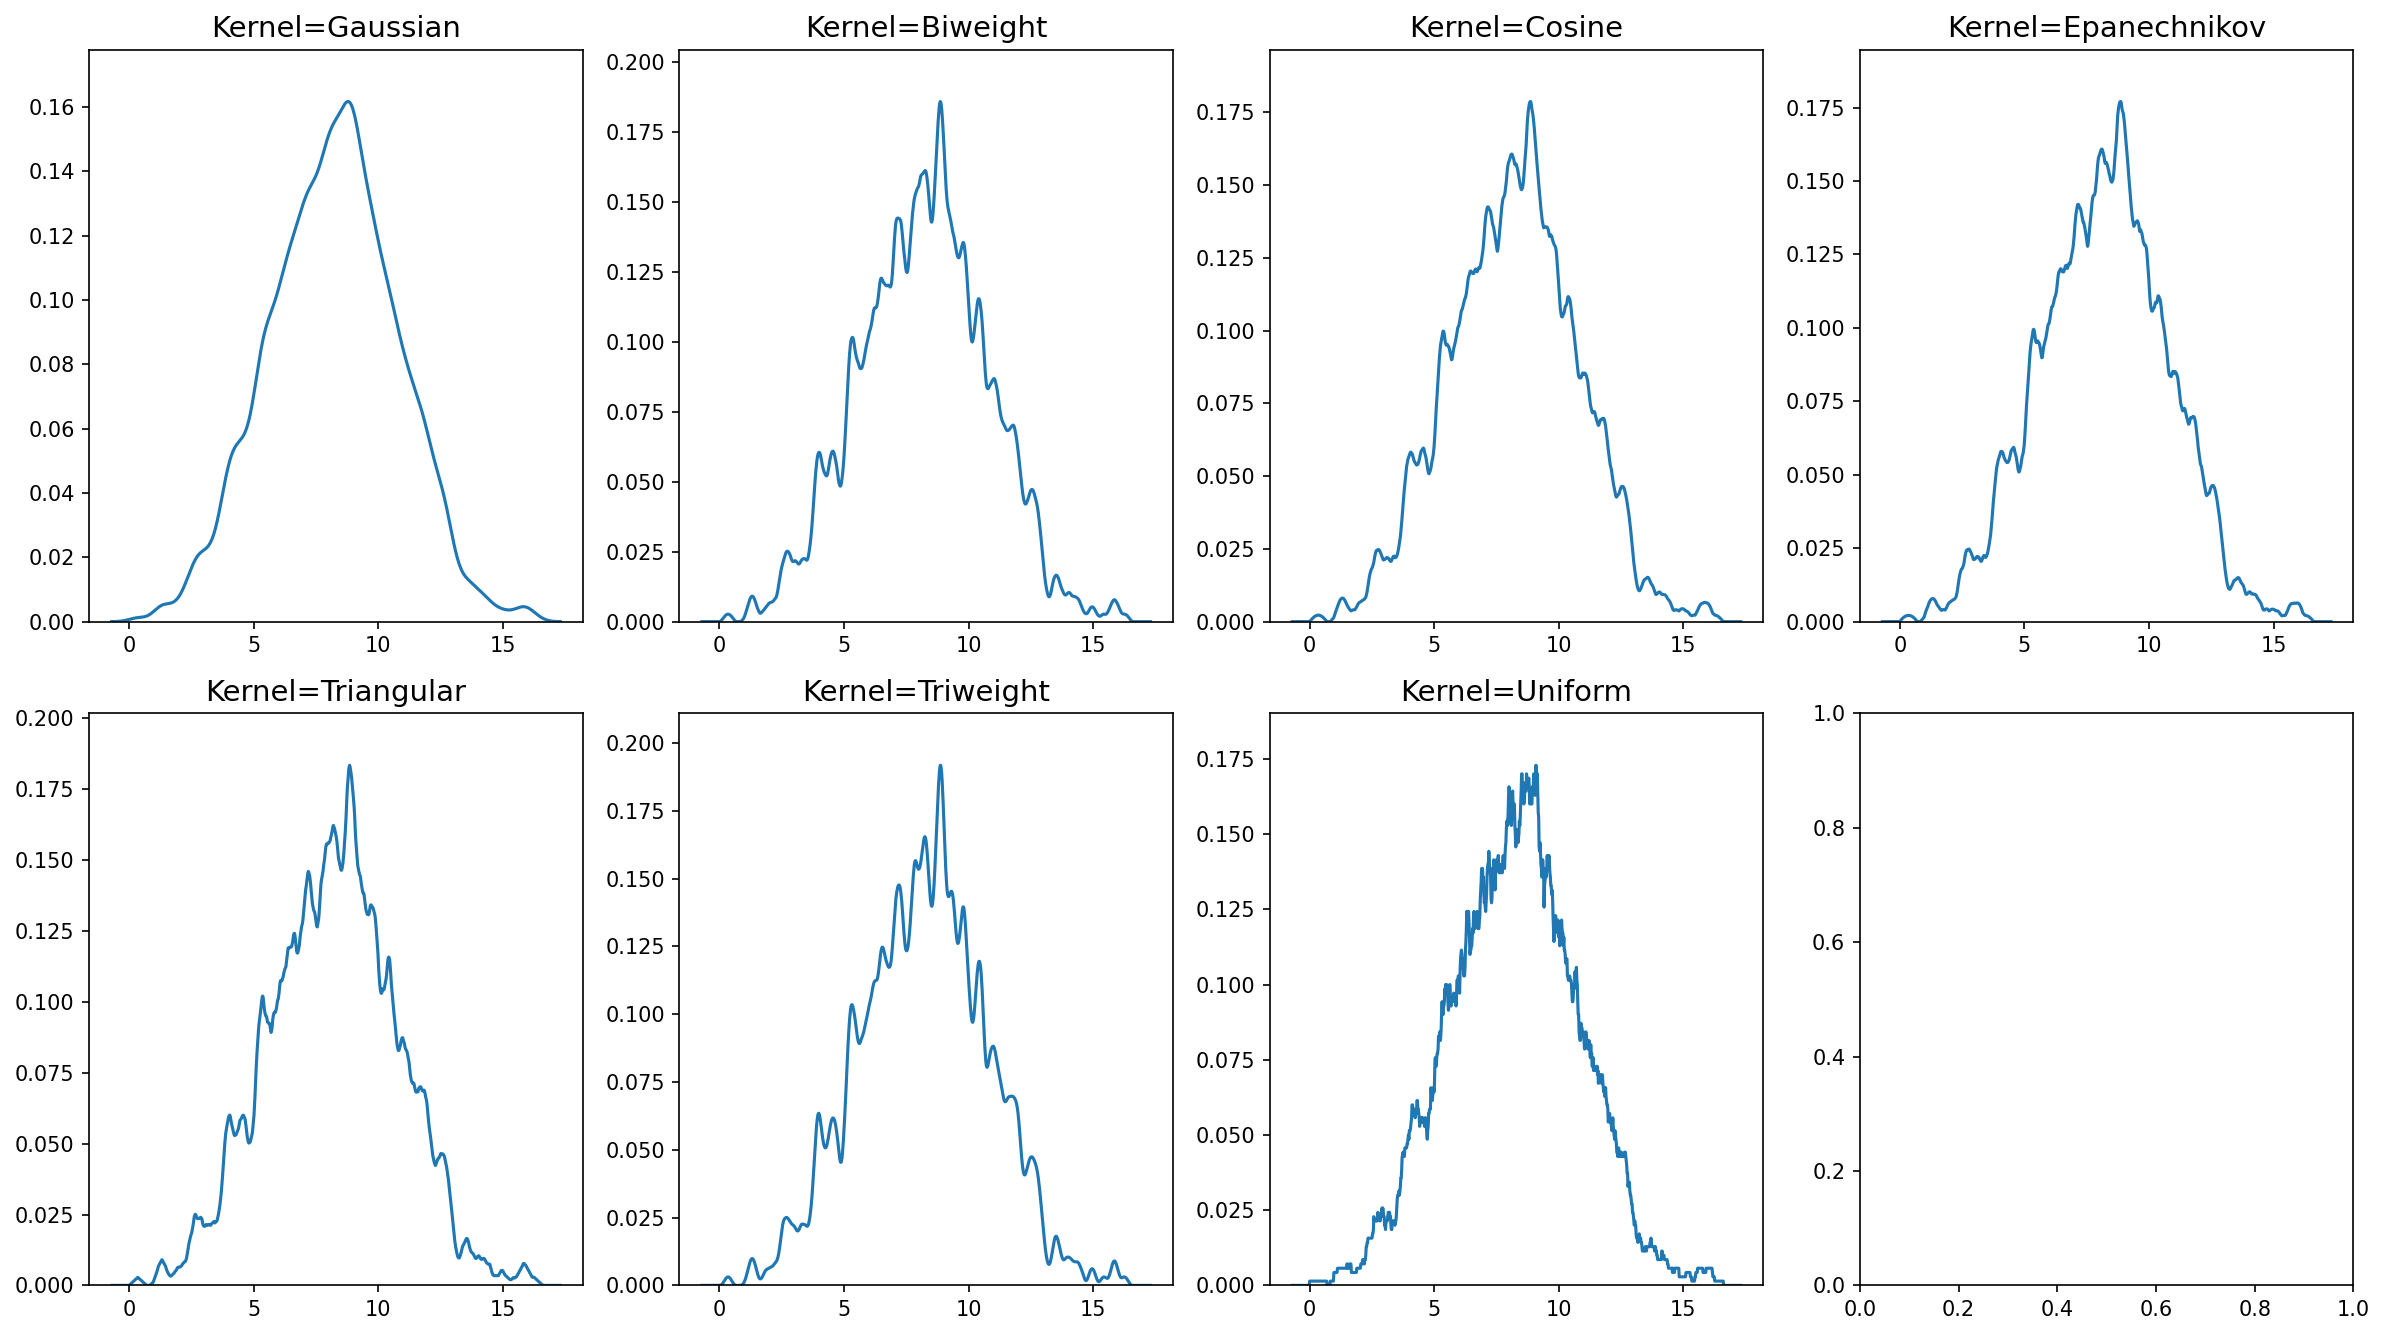

In [7]:
# 定义不同的核函数
kernels = ['gau', 'biw', 'cos', 'epa', 'tri', 'triw', 'uni']

fig, axes = plt.subplots(2, 4, figsize=(16, 9), dpi=150)
axes = axes.flatten()

kernel_full_names = {
    'gau': 'Gaussian',
    'biw': 'Biweight',
    'cos': 'Cosine',
    'epa': 'Epanechnikov',
    'tri': 'Triangular',
    'triw': 'Triweight',
    'uni': 'Uniform'
}

for i, kernel in enumerate(kernels):
    dens = smn.KDEUnivariate(X.flatten())
    # 进行核密度估计拟合
    result = dens.fit(bw=book_bandwidth, kernel=kernel, fft=False)
    axes[i].set_title(f'Kernel={kernel_full_names[kernel]}', size=14)
    # 绘制核密度估计曲线
    axes[i].plot(dens.support, result.density)
    axes[i].set_ylim(0, max(result.density) * 1.1)

plt.tight_layout()
plt.show()